pip install pandas
pip install mysql-connector-python
pip install matplotlib
pip install seaborn

In [36]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345678',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/vikas/OneDrive/Desktop/Bangalore/1st_project_Python&Sql/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [49]:
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345678',
    database='ecommerce'
)
cur = conn.cursor()

# 1. List all unique cities where customers are located. 


In [34]:
query = """ select distinct customer_city from customers
            order by customer_city 
            limit 5"""
cur.execute(query)
data = cur.fetchall()
data


[('abadia dos dourados',),
 ('abadiania',),
 ('abaete',),
 ('abaetetuba',),
 ('abaiara',)]

# 2. Count the number of orders placed in 2017. 

In [5]:
query = """ select count(order_id) from orders 
            where year(order_purchase_timestamp) = 2017;  """
cur.execute(query)
data2 = cur.fetchall()
# "Total orders placed in 2017 are  =",data2[0][0]

print("Total orders placed in 2017 are  =",data2[0][0] ) 
# if we call data[0] index then we get tupple (45101) and then data[0][0] for value 

Total orders placed in 2017 are  = 90202


# 3. Find the total sales per category.


In [6]:
query = """ select  upper(p.product_category), round(sum(pay.payment_value),2) as total_sales
    from products as p
    join order_items as o
    on p.product_id = o.product_id
    join payments as pay
    on pay.order_id = o.order_id
    group by p.product_category
    order by p.product_category """
cur.execute(query)
data3 = cur.fetchall()
data3
df = pd.DataFrame(data3, columns = ["Category", "Sales"])
df

,Category,Sales
0,None,2022413.68
1,AGRO INDUSTRIA E COMERCIO,949844.88
2,ART,247943.44
3,ARTS AND CRAFTS,18609.36
4,AUDIO,482596.96
...,...,...
69,STATIONARY STORE,2539520.56
70,TECHNICAL BOOKS,199323.52
71,TELEPHONY,3895056.41
72,TOYS,4952301.52


# 4. Calculate the percentage of orders that were paid in installments.


In [39]:
query = """ select (sum(case when payment_installments > 1 then 1 else 0 end)) / count(*)*100
 as installments_percent from payments; """
cur.execute(query)
data4 = cur.fetchall()
print("The percentage of orders that were paid in installments is", data4[0][0], "%")

The percentage of orders that were paid in installments is 49.4176 %


# 5. Count the number of customers from each state. 


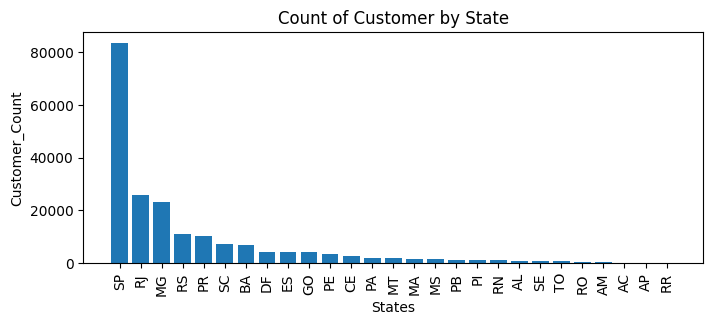

In [38]:
query = """ select customer_state, count(customer_state) as count from customers
group by customer_state """
cur.execute(query)
data5 = cur.fetchall()

df1 = pd.DataFrame(data5, columns = ["State_Name", "Counts"])
df1 = df1.sort_values(by = "Counts", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df1["State_Name"], df1['Counts'])
plt.xlabel("States")
plt.ylabel("Customer_Count")
plt.title("Count of Customer by State")
plt.xticks(rotation = 90)
plt.show()

# 6. Calculate the number of orders per month in 2018.


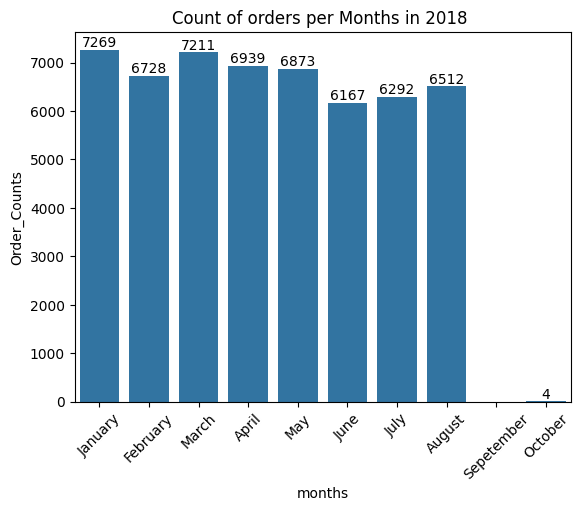

In [70]:
query = """ select monthname(order_purchase_timestamp)  as months, 
count(order_id) as order_count 
            from orders 
            where year(order_purchase_timestamp) = 2018
            group by months
            order by months;"""
cur.execute(query)
data6 = cur.fetchall()



df3 = pd.DataFrame(data6, columns = ["months", "Order_Counts"])
o = ["January","February","March","April","May","June","July","August","Sepetember","October"]

ax = sns.barplot(x = df3["months"], y = df3["Order_Counts"], data = df3, order = o)
plt.xticks(rotation = 45)
plt.title("Count of orders per Months in 2018 ")

ax.bar_label(ax.containers[0])
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [83]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city  """

cur.execute(query)
data7 = cur.fetchall()
df7 = pd.DataFrame(data7, columns = ["customer city", "sales%"])
df7

,customer city,sales%
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00


In [84]:
df7.head(10)

,customer city,sales%
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
5,rio de janeiro,1.15
6,mario campos,1.33
7,guariba,1.00
8,cuiaba,1.20
9,franca,1.25


# 8. Calculate the percentage of total revenue contributed by each product category

In [51]:
query = """select upper(products.product_category) as category,
           round((sum(payments.payment_value)/ (select sum(payment_value) from payments)) *100, 2) 
           as sales_percentage
           from products join order_items
           on products.product_id = order_items.product_id
           join payments 
           on payments.order_id = order_items.order_id
           group by category 
           order by sales_percentage desc """
cur.execute(query)
data8 = cur.fetchall()
df8 = pd.DataFrame(data8, columns = ["Category", "percentage distribution" ])
df8

,Category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
...,...,...
69,PC GAMER,0.05
70,HOUSE COMFORT 2,0.04
71,CDS MUSIC DVDS,0.03
72,FASHION CHILDREN'S CLOTHING,0.02


# 9. Identify the correlation between product price and the number of times a product has been purchased.


In [39]:
query = """select upper(products.product_category), 
count(order_items.product_id)as order_count,
round(avg(order_items.price),2) as avg_price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data9 = cur.fetchall()
df9 = pd.DataFrame(data9, columns = ["product_category","order_count", "avg_price"])
df9

,product_category,order_count,avg_price
0,HEALTH BEAUTY,38680,130.16
1,SPORT LEISURE,34564,114.34
2,COOL STUFF,15184,167.36
3,COMPUTER ACCESSORIES,31308,116.51
4,WATCHES PRESENT,23964,201.14
...,...,...,...
69,FLOWERS,132,33.64
70,KITCHEN PORTABLE AND FOOD COACH,60,264.57
71,CITTE AND UPHACK FURNITURE,152,114.95
72,HOUSE COMFORT 2,120,25.34


In [41]:
import numpy as np

arr1 = df9["order_count"]
arr2 = df9["avg_price"]

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# We can take this correlation as neutral because it is very close to zero 

# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [42]:
query = """select *, dense_rank() over(order by revenue desc)  as rn
from
(select order_items.seller_id, round(sum(payments.payment_value),2) 
			as revenue
            from order_items join payments
            on order_items.order_id = payments.order_id
            group by order_items.seller_id ) as a ;"""

cur.execute(query)
data10 = cur.fetchall()
df10 = pd.DataFrame(data10, columns  = ['seller', 'revenu', 'rank'])
df10.head(5)

,seller,revenu,rank
0,7c67e1448b00f6e969d365cea6b010ab,2028667.63,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1232888.16,2
2,4a3ca9315b744ce9f8e9374361493884,1204981.08,3
3,1f50f920176fa81dab994f9023523100,1161013.68,4
4,53243585a1d6dc2643021fd1853d8905,1139612.32,5


In [43]:
df10.tail(5)

,seller,revenu,rank
3090,ad14615bdd492b01b0d97922e87cb87f,76.84,3076
3091,702835e4b785b67a084280efca355756,74.24,3077
3092,4965a7002cca77301c82d3f91b82e1a9,65.44,3078
3093,77128dec4bec4878c37ab7d6169d6f26,60.88,3079
3094,cf6f6bc4df3999b9c6440f124fb2f687,48.88,3080


# 11. Calculate the moving average of order values for each customer over their order history.


In [121]:
query = """select customer_id, order_purchase_timestamp, 
	avg(payment) over(partition by customer_id order by order_purchase_timestamp
	rows between 2 preceding and current row) as mov_avg
from
	(select orders.customer_id, orders.order_purchase_timestamp,
	payments.payment_value as payment
	from payments join orders
	on payments.order_id = orders.order_id) as a;"""

cur.execute(query)
data11 = cur.fetchall()
df11 = pd.DataFrame(data11, columns = ['customer_id', 'order_time', 'moving_avrage'])
df11.tail(10)

,customer_id,order_time,moving_avrage
103876,fffb97495f78be80e2759335275df2aa,2018-01-16 14:51:35,61.009998
103877,fffc22669ca576ae3f654ea64c8f36be,2017-06-30 11:21:11,101.559998
103878,fffcb937e9dd47a13f05ecb8290f4d3e,2018-03-17 00:55:27,91.910004
103879,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.230003
103880,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,40.360002
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
103885,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001


# 12. Calculate the cumulative sales per month for each year.
    

#     sales - cumulative sales
        200 - 200
        300 - 500
        600 - 1100
        300 - 1400
        800 - 2200

In [12]:
query =  """ select years, months,payment, sum(payment)
over(order by years, months) cumulative_sales from

(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(orders.order_purchase_timestamp), 2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months
order by years, months) as a """

cur.execute(query)
data12  = cur.fetchall()

df12 = pd.DataFrame(data12, columns = ["years", "months", "sales", "cumulative_sales"])

df12



,years,months,sales,cumulative_sales
0,2016,9,24192.0,24192.0
1,2016,10,2757888.0,2782080.0
2,2016,12,8064.0,2790144.0
3,2017,1,6857800.0,9647944.0
4,2017,2,15216248.0,24864192.0
5,2017,3,22888916.0,47753108.0
6,2017,4,20742828.0,68495936.0
7,2017,5,31820192.0,100316128.0
8,2017,6,27721648.0,128037776.0
9,2017,7,34829556.0,162867332.0


In [14]:
print("total cumulative sum is ", sum(df12["cumulative_sales"]))

total cumulative sum is  8830677992.0


# 13. Calculate the year-over-year growth rate of total sales.


# (current year sales - previous year sales ) / previous year sales 

In [21]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(orders.order_purchase_timestamp), 2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years
order by years)

 select years, payment, lag(payment, 1) over(order by years) as previous_year
 from a
"""
cur.execute(query)

data13 = cur.fetchall()
df13  = pd.DataFrame(data13, columns = ["Years", "Total Sales", "Previous Sales"])
df13

,Years,Total Sales,Previous Sales
0,2016,2790144.0,NaN
1,2017,383431700.0,2790144.0
2,2018,452153080.0,383431700.0


In [25]:
df13["y-Over-y"] = (df13["Total Sales"] - df13["Previous Sales"])/ df13["Previous Sales"]

df13


,Years,Total Sales,Previous Sales,y-Over-y
0,2016,2790144.0,NaN,NaN
1,2017,383431700.0,2790144.0,136.423624
2,2018,452153080.0,383431700.0,0.179227


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.



In [27]:
query = """with a as (select customers.customer_id, 
min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp)
from a join orders 
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order , interval 6 month)
group by a.customer_id )

select 
  100 * (
    sum(case when b.customer_id is not null then 1 else 0 end) /
    count(distinct a.customer_id)
  ) as retention_rate
from a 
left join b on a.customer_id = b.customer_id;
"""

cur.execute(query)
data14 = cur.fetchall()
data14

[(Decimal('0.0000'),)]

# in our dataset, no customers make another purchase within 6 months of their first purchase.

# 15.  Identify the top 3 customers who spent the most money in each year

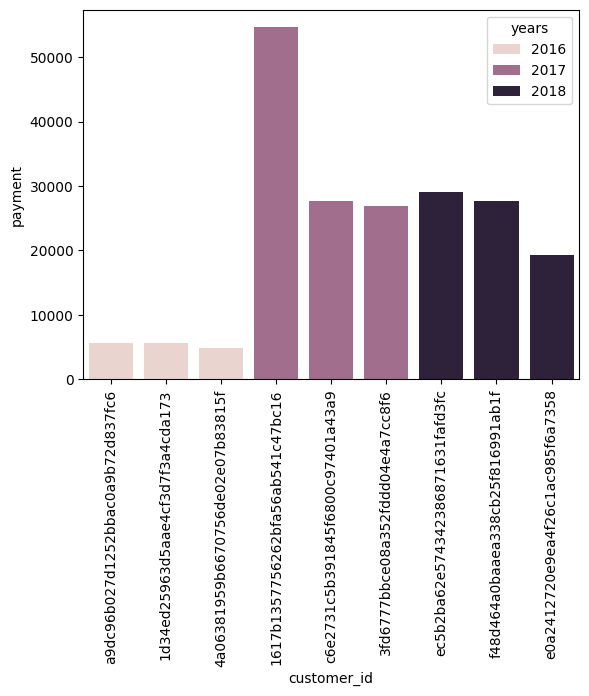

In [56]:
query = """select years, customer_id, payment, d_rank from
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;
"""

cur.execute(query)
data15 = cur.fetchall()
df15 = pd.DataFrame(data15, columns = ["years", "customer_id", 'payment', 'rank'])
sns.barplot(x = "customer_id", y = "payment", data = df15, hue = "years")
plt.xticks(rotation = 90)
plt.show()